# This notebook contains experiments with News data

In [1]:
import numpy as np
import pandas as pd
from experiment_utils import *
# Adjust the path for Jupyter notebooks
import os
import sys
from joblib import dump,load
from tqdm import tqdm


home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from comparator.DOPE.estimators import *

src_path = os.path.abspath("../src")
sys.path.append(src_path)

from models import *
from utils import *


p = 3477
import matplotlib.pyplot as plt
import seaborn as sns


import contextlib
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import io
@contextlib.contextmanager
def suppress_r_output():
    r_output = io.StringIO()
    with contextlib.redirect_stdout(r_output), contextlib.redirect_stderr(r_output):
        yield

with suppress_r_output():
    robjects.r['source'](r'../comparator/CollaborativeLearning/models.r')
    run_comparator = robjects.globalenv['run_comparator']

In [ ]:
def news_trial_single(exp_num=1, train_size=1, p=3477,
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', 
                          random_seed=42, stds_return=True, coverage_return=False):

    df = News(exp_num=exp_num,train_size=train_size).get_df()
    ate = np.mean(df['mu1']-df['mu0'])

    ates, stds, df_est = single_trial(
        true_ate=ate, df_full=df, p=p,
        ps_model=ps_model, or_model=or_model,
        w_model=w_model,
        random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
    )
    with suppress_r_output():
        r_df = pandas2ri.py2rpy(df_est)
        r_result = run_comparator(df=r_df, p=p, propen_est=True, mu_est=True,random_seed=random_seed)
        result = dict(zip(r_result.names, list(r_result)))


    # dope
    X_cols = [f"X{i}" for i in range(1, p + 1)]
    ates_dope, vars_dope = SI_IM_cf(T=df['A'].values,Y=df['y'].values, W=df[X_cols].values)

    all_ate = {'true_ate':ate,
                'ate_tmle':result['ate.tmle'][0],
                'ate_ctmle':result['ate.ctmle'][0],
                'ate_cbps':result['ate.cbps'][0],
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw'],
                'ate_siaipw': ates_dope[1],
                'ate_sioapw': ates_dope[2],
                'ate_siobpw': ates_dope[3]}

    all_std = {
                'std_tmle':result['sd.tmle'][0],
                'std_ctmle':result['sd.ctmle'][0],
                'std_cbps':result['sd.cbps'][0],
                'std_mr':stds['ate_mr'],
                'std_ipw':stds['ate_ipw'],
                'std_amr':stds['ate_amr'],
                'std_aipw':stds['ate_aipw'],
                'std_siaipw':np.sqrt(vars_dope[1]),
                'std_sioapw':np.sqrt(vars_dope[2]),
                'std_siobpw': np.sqrt(vars_dope[3])
                }
    return all_ate, all_std
def news_trial(num_trials=50, train_size=1, p=3477, cross_fit=True, 
                n_folds=5, ps_model='torch_nn',or_model='torch_nn',w_model='kernel_ridge_regression', 
                random_seed=42, stds_return=True, coverage_return=False):
    ate_results = {'true_ate':[],
                'ate_tmle':[],
                'ate_ctmle':[],
                'ate_cbps':[],
                'ate_mr':[],
                'ate_ipw':[],
                'ate_amr':[],
                'ate_aipw':[],
                'ate_siaipw':[],
                'ate_sioapw':[],
                'ate_siobpw':[]}

    std_results = {
                'std_tmle':[],
                'std_ctmle':[],
                'std_cbps':[],
                'std_mr':[],
                'std_ipw':[],
                'std_amr':[],
                'std_aipw':[],
                'std_siaipw':[],
                'std_sioapw':[],
                'std_siobpw':[]
                }

    
    for i in tqdm(range(num_trials)):

        single_all_ate, single_all_std = news_trial_single(exp_num=i+1, train_size=train_size, p=p, 
                                                        cross_fit=cross_fit, n_folds=n_folds, ps_model=ps_model,
                                                        or_model=or_model,w_model=w_model, random_seed=random_seed, 
                                                        stds_return=stds_return, coverage_return=coverage_return)
        for key, value in single_all_ate.items():
            ate_results[key].append(value)
        for key, value in single_all_std.items():
            std_results[key].append(value)

    return ate_results, std_results

In [3]:
df = News(exp_num=2,train_size=1).get_df()

(array([ 965.,  436.,  325.,  258.,  229.,  253.,  315.,  373.,  521.,
        1325.]),
 array([6.60076012e-20, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

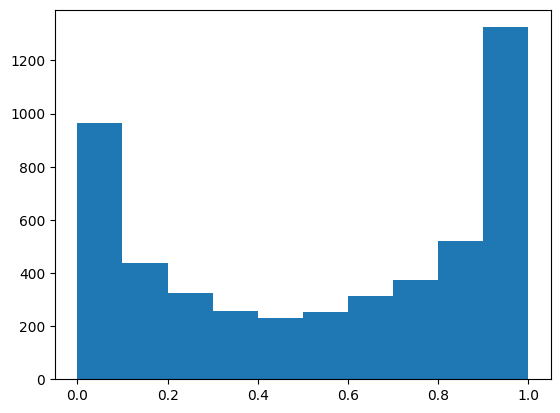

In [4]:
X_cols = [f"X{i}" for i in range(1, p + 1)]
ps_model = LogisticRegression(random_state=42, max_iter=1000) 
ps_model.fit(df[X_cols].values, df['A'].values)
p_train = ps_model.predict_proba(df[X_cols].values)[:, 1]
plt.hist(p_train)

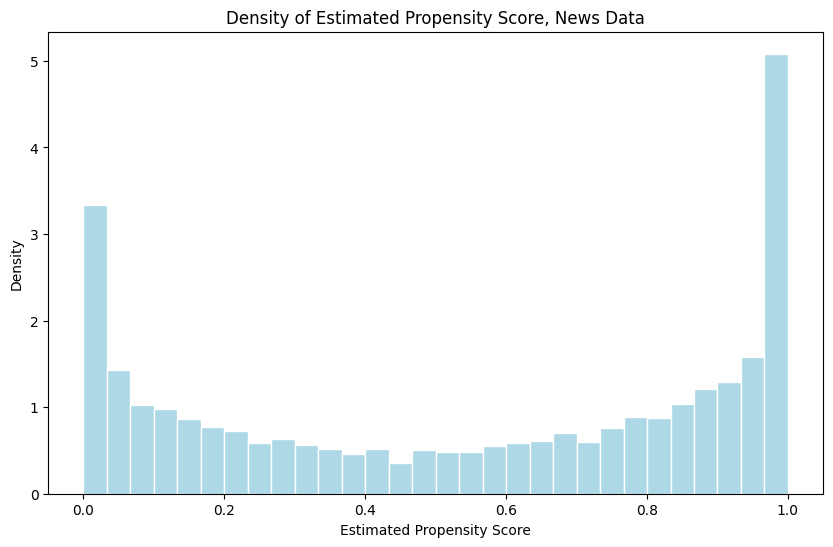

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot the histogram with a fancier color (e.g., lightblue) and add a black edge to each bin
plt.hist(p_train, bins=30, color='lightblue', edgecolor='white', density = True)

# Add the x and y labels
plt.xlabel('Estimated Propensity Score')
plt.ylabel('Density')

# Add a LaTeX-formatted title (you can also use 'coral' for a different color)
plt.title('Density of Estimated Propensity Score, News Data')

# Display the plot
plt.show()


In [6]:
ate_results, std_results = news_trial(num_trials=50,train_size=1)

100%|██████████| 50/50 [11:26<00:00, 13.72s/it]


In [7]:
# Define the file path
ate_output_file = "results/news/ate_dope.joblib"
std_output_file = "results/news/std_dope.joblib"

# Ensure the directory exists
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)

# Save the results using joblib
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")

Results saved to results/news/ate_dope.joblib
Results saved to results/news/std_dope.joblib


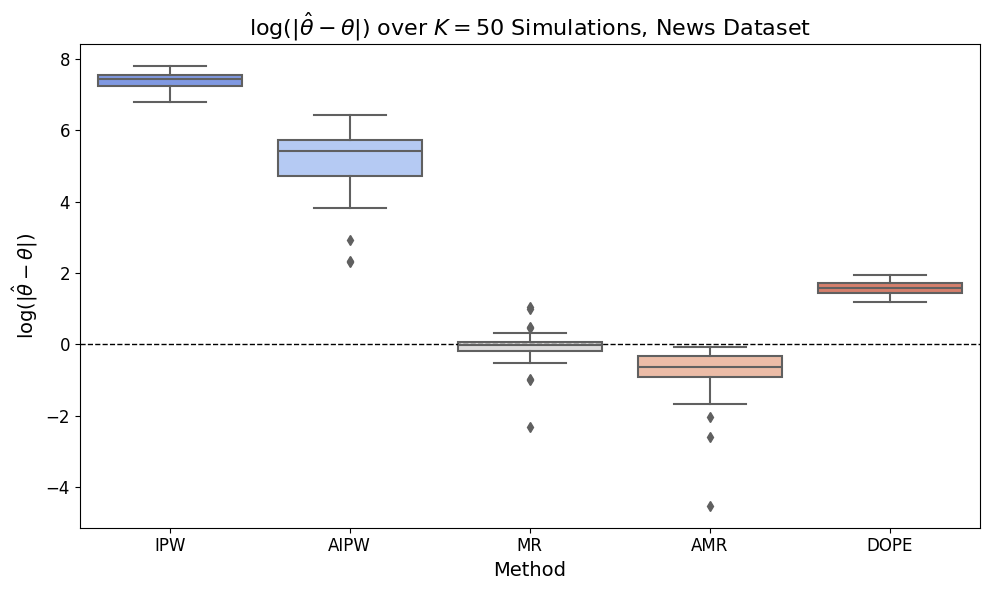

\begin{table}
\begin{center}
\begin{tabular}{lrrrrrr}
\toprule
     & \textbf{IPW} & \textbf{AIPW} & \textbf{MR} & \textbf{AMR} & \textbf{DOPE\_SIAIPW} & \textbf{DOPE\_OAPW}\\
\midrule
Bias & $1.66\times 10^{3}$ & $-225$ & $-0.953$ & $-\textbf{0.532}$ & $6.07$ & $4.74$ \\
MAE & $1.66\times 10^{3}$ & $232$ & $1.01$ & $\textbf{0.535}$ & $9.67$ & $4.74$ \\
RMSE & $1.7\times 10^{3}$ & $273$ & $1.11$ & $\textbf{0.582}$ & $11.6$ & $4.8$ \\
\bottomrule
\end{tabular}
\end{center}
\caption{Estimator performance on $K=50$ draws of data generating process in the \textit{News} dataset.}
\label{tab:performance_news}
\end{table}


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from joblib import load

# ----------------------------
# Load and merge the results
# ----------------------------
ate_results = load("results/news/ate.joblib")
ate_dope = load("results/news/ate_dope.joblib")

# Merge the DOPE results into ate_results (skip duplicate 'true_ate')
for key, value in ate_dope.items():
    if key != "true_ate":
        ate_results[key] = value

# ----------------------------
# Define methods and display names
# ----------------------------
# All estimators (including DOPE estimators)
methods = [
    'ate_ipw', 
    'ate_aipw', 
    'ate_mr', 
    'ate_amr', 
    'ate_siaipw', 
    'ate_sioapw', 
    'ate_siobpw'
]

# Mapping: drop "ate_" for standard methods; add "DOPE_" for the others.
short_methods = {
    'ate_ipw': 'IPW',
    'ate_aipw': 'AIPW',
    'ate_mr': 'MR',
    'ate_amr': 'AMR',
    'ate_siaipw': 'DOPE_SIAIPW',
    'ate_sioapw': 'DOPE',
    'ate_siobpw': 'DOPE_SIOBPW'
}

# True ATE (assumed to be identical in both files)
true_ate = np.array(ate_results['true_ate'])

# ----------------------------
# Create log–plot of |bias|
# ----------------------------
# We plot only the log of absolute bias: log(|estimates - true_ate|).
plot_data = []
for method in methods:
    estimates = np.array(ate_results[method])
    abs_bias = np.abs(estimates - true_ate)
    # Avoid log(0) issues: select only values > 0
    abs_bias_nonzero = abs_bias[abs_bias > 0]
    if len(abs_bias_nonzero) > 0:
        log_abs_bias = np.log(abs_bias_nonzero)
        df_temp = pd.DataFrame({
            'Method': [short_methods[method]] * len(log_abs_bias),
            'Value': log_abs_bias
        })
        plot_data.append(df_temp)
plot_df = pd.concat(plot_data)

# Set a categorical ordering (all seven estimators)
ordered_methods = ['IPW', 'AIPW', 'MR', 'AMR', 'DOPE']
plot_df['Method'] = pd.Categorical(plot_df['Method'], categories=ordered_methods, ordered=True)

plt.figure(figsize=(10, 6))

# Use a different palette like 'Set2' for nicer colors:
ax = sns.boxplot(data=plot_df, x='Method', y='Value', palette='coolwarm')

# Draw a horizontal line at y=0:
ax.axhline(0, color='black', linestyle='--', linewidth=1)

ax.set_title(r'$\log(|\hat{\theta}-\theta|)$ over $K=50$ Simulations, News Dataset', fontsize=16)
ax.set_xlabel('Method', fontsize=14)
ax.set_ylabel(r'$\log(|\hat{\theta}-\theta|)$', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


# ----------------------------
# Compute summary statistics for the four standard methods only
# ----------------------------
# We'll compute:
#   Bias = mean(estimates - true_ate)
#   MAE = mean(|estimates - true_ate|)
#   RMSE = sqrt(mean((estimates - true_ate)^2))
import numpy as np
import pandas as pd

# Assume ate_results is already loaded and merged, and true_ate is defined.
true_ate = np.array(ate_results['true_ate'])

# Compute summary statistics for standard estimators and DOPE_SIAIPW.
# Standard methods: IPW, AIPW, MR, AMR.
methods = {
    'IPW': 'ate_ipw',
    'AIPW': 'ate_aipw',
    'MR': 'ate_mr',
    'AMR': 'ate_amr',
    'DOPE_SIAIPW': 'ate_siaipw'
}

summary_stats = {}

for disp_name, key in methods.items():
    estimates = np.array(ate_results[key])
    bias  = np.mean(estimates - true_ate)
    mae   = np.mean(np.abs(estimates - true_ate))
    rmse  = np.sqrt(np.mean((estimates - true_ate)**2))
    summary_stats[disp_name] = {'Bias': bias, 'MAE': mae, 'RMSE': rmse}

# For DOPE OAPW, combine estimates from ate_sioapw and ate_siobpw (element‐wise average).
est_sioapw  = np.array(ate_results['ate_sioapw'])
est_siobpw  = np.array(ate_results['ate_siobpw'])
combined    = (est_sioapw + est_siobpw) / 2

bias  = np.mean(combined - true_ate)
mae   = np.mean(np.abs(combined - true_ate))
rmse  = np.sqrt(np.mean((combined - true_ate)**2))
summary_stats['DOPE_OAPW'] = {'Bias': bias, 'MAE': mae, 'RMSE': rmse}

# Determine the best performance for each metric (lowest absolute Bias, MAE, RMSE)
best_bias = min(summary_stats, key=lambda m: abs(summary_stats[m]['Bias']))
best_mae  = min(summary_stats, key=lambda m: summary_stats[m]['MAE'])
best_rmse = min(summary_stats, key=lambda m: summary_stats[m]['RMSE'])

# Function to format numbers with 3 significant digits and convert to LaTeX style if in scientific notation.
def format_number(x):
    s = "{:.3g}".format(x)
    if "e" in s:
        base, exp = s.split("e")
        exp = exp.replace("+", "")
        exp = exp.lstrip("0")
        if exp == "":
            exp = "0"
        s = f"{base}\\times 10^{{{exp}}}"
    return s

# Build the LaTeX table.
# The table will show: IPW, AIPW, MR, AMR, DOPE_SIAIPW, and the combined DOPE_OAPW.
latex_lines = []
latex_lines.append(r"\begin{table}")
latex_lines.append(r"\begin{center}")
latex_lines.append(r"\begin{tabular}{lrrrrrr}")
latex_lines.append(r"\toprule")
latex_lines.append(r"     & \textbf{IPW} & \textbf{AIPW} & \textbf{MR} & \textbf{AMR} & \textbf{DOPE\_SIAIPW} & \textbf{DOPE\_OAPW}\\")
latex_lines.append(r"\midrule")

for metric in ['Bias', 'MAE', 'RMSE']:
    row = [metric]
    for method in ['IPW', 'AIPW', 'MR', 'AMR', 'DOPE_SIAIPW', 'DOPE_OAPW']:
        value = summary_stats[method][metric]
        formatted = format_number(value)
        # For Bias, bold the estimator with smallest absolute bias;
        # for MAE and RMSE, bold the lowest value.
        if metric == 'Bias' and method == best_bias:
            if formatted.startswith("-"):
                formatted = "-" + r"\textbf{" + formatted[1:] + "}"
            else:
                formatted = r"\textbf{" + formatted + "}"
        elif metric == 'MAE' and method == best_mae:
            formatted = r"\textbf{" + formatted + "}"
        elif metric == 'RMSE' and method == best_rmse:
            formatted = r"\textbf{" + formatted + "}"
        row.append(f"${formatted}$")
    latex_lines.append(" & ".join(row) + r" \\")
 
latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\end{center}")
latex_lines.append(r"\caption{Estimator performance on $K=50$ draws of data generating process in the \textit{News} dataset.}")
latex_lines.append(r"\label{tab:performance_news}")
latex_lines.append(r"\end{table}")

latex_table = "\n".join(latex_lines)
print(latex_table)